In [1]:
import time
start_time = time.time()

In [2]:
import logging
from pathlib import Path

import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn

from dask.distributed import Client

import dcor

from stein_thinning.thinning import thin_gf

import lotka_volterra
from thinning import gaussian_thin, laplace_approximation
import utils.caching
from utils.caching import cached
from utils.ksd import calculate_ksd
from utils.parallel import apply_along_axis_parallel, get_map_parallel
from utils.paths import GENERATED_DATA_PATH
from utils.plotting import centered_subplots, highlight_points, plot_paths, plot_sample_thinned, plot_traces
from utils.sampling import to_arviz

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

Directory where results of expensive calculations will be stored:

In [6]:
utils.caching.cache_dir = GENERATED_DATA_PATH

In [7]:
recalculate = False  # True => perform expensive calculations, False => use stored results
save_data = recalculate

We create a Dask client in order to parallelise calculations where possible:

In [8]:
client = Client(processes=True, threads_per_worker=4, n_workers=4, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44941,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:43557,Total threads: 4
Dashboard: http://127.0.0.1:40011/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:46791,


In [9]:
map_parallel = get_map_parallel(client)

Input parameters

In [10]:
n_chains = len(lotka_volterra.theta_inits)

In [11]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in lotka_volterra.theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(lotka_volterra.d)]

Read-only input datasets:

In [12]:
@cached(item_type=np.ndarray, batch_size=n_chains, read_only=True)
def rw_samples() -> list[np.ndarray]:
    raise NotImplemented

In [13]:
@cached(item_type=np.ndarray, batch_size=n_chains, read_only=True)
def rw_thinned_idx() -> list[np.ndarray]:
    raise NotImplemented

In [14]:
@cached(item_type=np.ndarray, batch_size=n_chains, read_only=True)
def validation_hmc_samples() -> list[np.ndarray]:
    raise NotImplemented

In [15]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_1
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_2
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_3
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_4
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_4.npy


# Gradient-free Stein thinning

In [16]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

We recalculate the (unnormalised) log target density for all samples. Note that in principle we could have stored it during the MCMC run rather than recalculating it.

In [17]:
@cached(batch_size=n_chains)
def rw_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(log_target_density, rw_samples[i])

In [18]:
@cached(batch_size=n_chains)
def hmc_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(log_target_density, hmc_samples[i])

## Full sample

### Laplace proxy

In [19]:
%%time
laplace_mean, laplace_cov = laplace_approximation(lotka_volterra.log_target_density, np.mean(rw_samples[0], axis=0))

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_samples_0.npy


CPU times: user 1.49 s, sys: 106 ms, total: 1.6 s
Wall time: 1.48 s


In [20]:
laplace_mean

array([-0.38253112,  0.29246496, -0.01989887, -0.01793044])

In [21]:
laplace_cov

array([[ 2.34793458e-05,  3.60158614e-05, -1.53824886e-05,
         3.46689365e-07],
       [ 3.60158614e-05,  6.56180950e-05, -2.12565683e-05,
        -2.70110977e-06],
       [-1.53824886e-05, -2.12565683e-05,  1.18664414e-05,
         4.49855438e-07],
       [ 3.46689365e-07, -2.70110977e-06,  4.49855439e-07,
         2.58154310e-06]])

The method clearly fails in this case:

In [22]:
gaussian_thin(rw_samples[0], rw_log_p[0], laplace_mean, laplace_cov, n_points_thinned)

DEBUG:utils.caching:Reading from disk cache: rw_log_p_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_log_p_0.npy
/home/artem/git/stein_thinning/stein_thinning/thinning.py:126: UserWarning: log_q differs from log_p by more than 10 - consider using q that matches target better
  warnings.warn(f'log_q differs from log_p by more than {WEIGHT_SCALE_THRESHOLD} - consider using q that matches target better')


array([231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231,
       231, 231, 231, 231, 231, 231, 231], dtype=uint32)

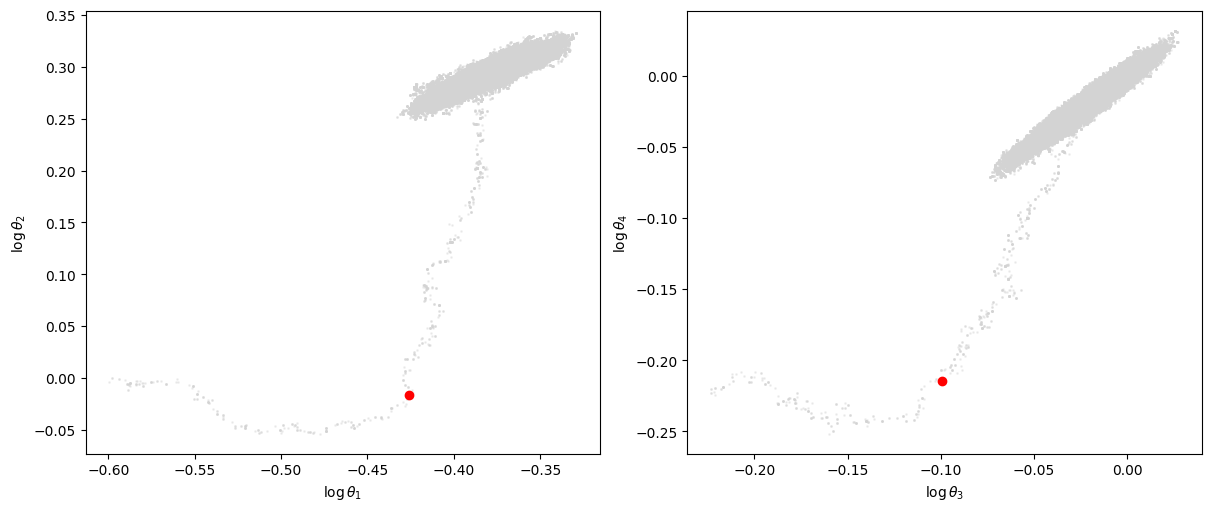

In [23]:
points_to_highlight = [231]

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(rw_samples[0], points_to_highlight, [(0, 1), (2, 3)], axs, var_labels);

We calculate the proxy density at element 231:

In [24]:
log_q = mvn.logpdf(rw_samples[0], mean=laplace_mean, cov=laplace_cov)

In [25]:
log_q[231]

-26032762.34574922

In [26]:
rw_log_p[0][231]

-1290.111884958963

#### Numerical stability of optimisation

Using the default parameters in `scipy.optimize.minimize` results in a failure to find the optimum:

In [27]:
x0 = np.mean(rw_samples[0], axis=0)
res = minimize(lambda x: -lotka_volterra.log_target_density(x), x0)
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -852.0640163220094
        x: [-3.825e-01  2.925e-01 -1.990e-02 -1.793e-02]
      nit: 9
      jac: [ 8.316e-04 -5.646e-04 -7.629e-06  2.441e-04]
 hess_inv: [[ 7.863e-06  1.394e-05 -2.236e-06  2.310e-06]
            [ 1.394e-05  3.830e-05 -1.929e-06 -1.293e-06]
            [-2.236e-06 -1.929e-06  9.404e-07 -1.463e-06]
            [ 2.310e-06 -1.293e-06 -1.463e-06  2.815e-06]]
     nfev: 160
     njev: 32

Nelder-Mead succeeds:

In [28]:
x0 = np.mean(rw_samples[0], axis=0)
res = minimize(lambda x: -lotka_volterra.log_target_density(x), x0, method='Nelder-Mead')
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -852.0637592194984
             x: [-3.822e-01  2.926e-01 -2.023e-02 -1.826e-02]
           nit: 36
          nfev: 69
 final_simplex: (array([[-3.822e-01,  2.926e-01, -2.023e-02, -1.826e-02],
                       [-3.823e-01,  2.927e-01, -2.018e-02, -1.823e-02],
                       ...,
                       [-3.822e-01,  2.927e-01, -2.025e-02, -1.824e-02],
                       [-3.823e-01,  2.926e-01, -2.021e-02, -1.825e-02]]), array([-8.521e+02, -8.521e+02, -8.521e+02, -8.521e+02,
                       -8.521e+02]))

However, the Hessian evaluated at the maximum does not appear to be negative definite:

In [29]:
from numdifftools import Hessian

In [30]:
%%time
hess = Hessian(lotka_volterra.log_target_density)(res.x)
hess

CPU times: user 5.01 s, sys: 511 ms, total: 5.53 s
Wall time: 5.44 s


array([[-1196095.2214617 ,   329406.57616248, -1108270.83676384,
          106697.01289121],
       [  329406.57616248,  -118085.88891696,   257880.48682208,
           -6315.21068702],
       [-1108270.83676384,   257880.48682208, -1147544.69390286,
          228865.43619375],
       [  106697.01289121,    -6315.21068702,   228865.43619375,
          -97166.87432036]])

In [31]:
np.linalg.eigvals(hess)

array([-2381433.96995493,  -181583.12354665,    22522.02454574,
         -18397.60964605])

In [32]:
def is_positive_definite(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [33]:
is_positive_definite(-hess)

False

### Simple Gaussian proxy

In [34]:
sample_mean = np.mean(rw_samples[0], axis=0)
sample_cov = np.cov(rw_samples[0], rowvar=False, ddof=lotka_volterra.d)

In [35]:
sample_mean

array([-0.38261842,  0.29176476, -0.02010969, -0.01824518])

In [36]:
sample_cov

array([[ 2.12987627e-04,  1.62995182e-04, -1.91636668e-04,
        -1.72343118e-04],
       [ 1.62995182e-04,  1.97250184e-04, -1.02375977e-04,
        -6.37599091e-05],
       [-1.91636668e-04, -1.02375977e-04,  2.16947410e-04,
         2.13353024e-04],
       [-1.72343118e-04, -6.37599091e-05,  2.13353024e-04,
         2.30906788e-04]])

In [37]:
idx = gaussian_thin(rw_samples[0], rw_log_p[0], sample_mean, sample_cov, n_points_thinned)
idx

/home/artem/git/stein_thinning/stein_thinning/thinning.py:126: UserWarning: log_q differs from log_p by more than 10 - consider using q that matches target better
  warnings.warn(f'log_q differs from log_p by more than {WEIGHT_SCALE_THRESHOLD} - consider using q that matches target better')


array([210376, 427710, 492726,  58196,  59929, 456038, 490046, 308139,
       427710,  12999, 428495, 283038,  80507, 269300, 490046, 377681,
       427710,  59944, 494516, 387883], dtype=uint32)

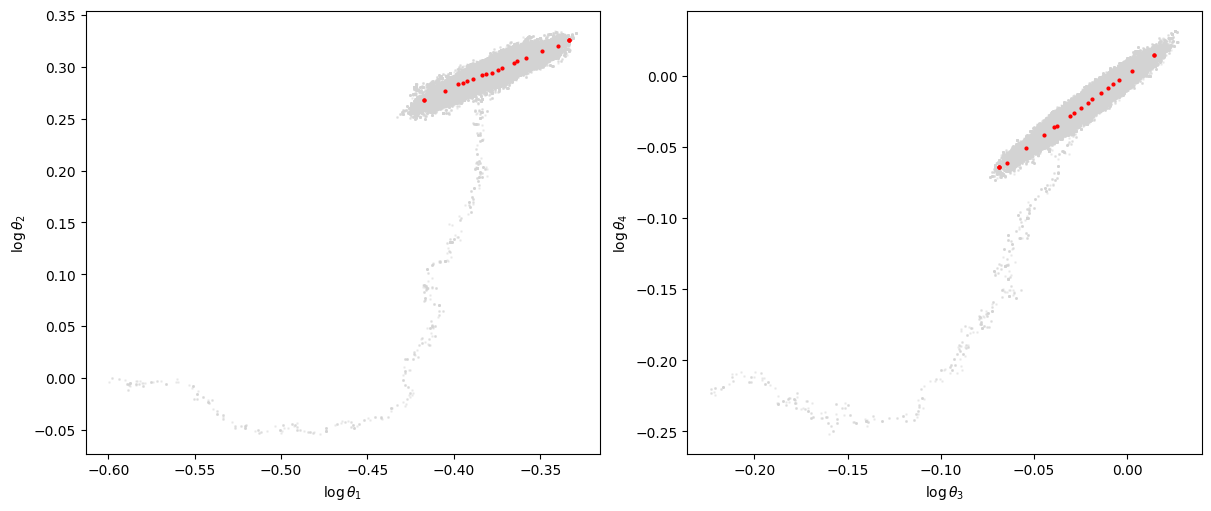

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(rw_samples[0], idx, [(0, 1), (2, 3)], axs, var_labels, highlighted_point_size=4);

In [39]:
log_q = mvn.logpdf(rw_samples[0], mean=sample_mean, cov=sample_cov)
gradient_q = -np.einsum('ij,kj->ki', np.linalg.inv(sample_cov), rw_samples[0] - sample_mean)

In [40]:
np.ptp(log_q - rw_log_p[0])

12428.96517387056

In [41]:
@cached(item_type=np.ndarray, batch_size=n_chains)
def rw_gf_simple_gaussian_idx() -> list[np.ndarray]:
    samples = list(rw_samples)
    log_ps = list(rw_log_p)
    def calculate(i):
        sample = samples[i]
        log_p = log_ps[i]
        sample_mean = np.mean(sample, axis=0)
        sample_cov = np.cov(sample, rowvar=False, ddof=lotka_volterra.d)
        return gaussian_thin(sample, log_p, sample_mean, sample_cov, n_points_calculate)
    return map_parallel(calculate, range(len(lotka_volterra.theta_inits)))

In [42]:
%%time
#rw_gf_simple_gaussian_idx.recalculate(True);

CPU times: user 4 μs, sys: 2 μs, total: 6 μs
Wall time: 10.3 μs


Notebook execution took:

In [43]:
time.time() - start_time

41.843888998031616